# 1D time domain EM inversion 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# SimPEG, discretize/
import discretize
from discretize import utils
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG.electromagnetics import resistivity as dc
from SimPEG.utils import mkvc, plot_1d_layer_model
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

from pymatsolver import Pardiso

## create a model 

In [2]:
rho_back = 100
sigma_layer = 0.1
layer_depth = np.r_[120, 160]

sigma_true = np.r_[1./rho_back, sigma_layer, 1./rho_back]
m_true = np.log(sigma_true)
layer_thicknesses_true = np.r_[layer_depth[0], np.diff(layer_depth)]

In [3]:
sigma_true

array([0.01, 0.1 , 0.01])

(400.0, 0.0)

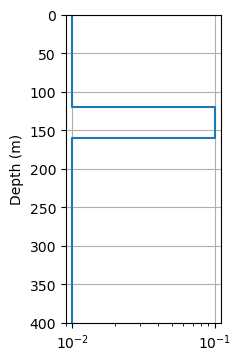

In [4]:
fig, ax = plt.subplots(1,1, figsize=(2, 4))
plot_1d_layer_model(layer_thicknesses_true, sigma_true, ax=ax, label="True")
ax.grid()
ax.set_ylim(np.r_[400, 0])

## set up a survey

In [5]:
rx_times = np.logspace(-4, -2, 20)

print(f"times: {rx_times.min()*1e3:1.0e}ms, {rx_times.max()*1e3:1.0e}ms")

times: 1e-01ms, 1e+01ms


In [6]:
rx_z = tdem.receivers.PointMagneticFluxDensity(
    np.r_[0, 0, 0], times=rx_times, orientation="z"
)

half_width = 100
src = tdem.sources.LineCurrent(
    location = np.array([
        [-half_width, -half_width, 0],
        [ half_width, -half_width, 0],
        [ half_width,  half_width, 0],
        [-half_width,  half_width, 0],
        [-half_width, -half_width, 0]
    ]),
    receiver_list = [rx_z]
)


survey = tdem.Survey([src])

## create synthetic data

In [7]:
sim1d_true = tdem.Simulation1DLayered(
    survey=survey, 
    thicknesses=layer_thicknesses_true, 
    sigmaMap=maps.ExpMap(nP=3)
)
dobs = sim1d_true.dpred(m_true)

Text(0, 0.5, 'B (nT)')

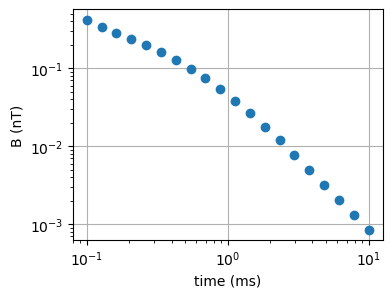

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
                       
ax.loglog(rx_times*1e3, dobs*1e9, "o")
ax.grid()
ax.set_xlabel("time (ms)")
ax.set_ylabel("B (nT)")

## set up the inversion

In [9]:
data_invert = data.Data(survey, dobs=dobs, relative_error=0.05)
data_invert[src, rx_z]

array([4.20757650e-10, 3.41104333e-10, 2.82498877e-10, 2.36130992e-10,
       1.96371354e-10, 1.60532445e-10, 1.27985877e-10, 9.91014061e-11,
       7.44226855e-11, 5.42275532e-11, 3.84030964e-11, 2.65042447e-11,
       1.78881220e-11, 1.18530932e-11, 7.74360047e-12, 5.00867301e-12,
       3.22024037e-12, 2.06520512e-12, 1.32499856e-12, 8.52363383e-13])

### create inversion mesh & simulation

In [10]:
cs_invert = 5
inv_thicknesses = np.hstack([[cs_invert]*int(300/cs_invert), cs_invert * np.logspace(0, 1.5, 20)])

In [11]:
mesh = discretize.TensorMesh([(np.r_[inv_thicknesses, inv_thicknesses[-1]])], origin="0")
mesh

TensorMesh: 81 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     81          0.00      1,384.28      5.00    158.11    1.20

In [12]:
sim1d = tdem.Simulation1DLayered(
    survey=survey, thicknesses=inv_thicknesses, sigmaMap=maps.ExpMap(mesh)
)

In [13]:
dmis = data_misfit.L2DataMisfit(simulation=sim1d, data=data_invert)
reg = regularization.WeightedLeastSquares(
    mesh,
    reference_model=np.log(1./rho_back),
)

opt = optimization.InexactGaussNewton(maxIter=30)
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Beta cooling schedule 
beta_cooling = directives.BetaSchedule(coolingFactor=2, coolingRate=2)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# target misfit -- stop the inversion when we have fit the data 
target_misfit = directives.TargetMisfit()

# The directives are defined as a list.
directives_list = [
    starting_beta,
    beta_cooling, 
    save_iteration,
    target_misfit, 
]

# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

In [14]:
starting_model = np.log(1./rho_back)*np.ones(mesh.n_cells)

recovered_model = inv.run(starting_model)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.12e+00  1.39e+03  0.00e+00  1.39e+03    3.20e+02      0              
   1  5.12e+00  4.09e+02  4.39e+01  6.34e+02    8.29e+01      0              
   2  2.56e+00  2.05e+02  6.60e+01  3.74e+02    8.83e+01      0              
   3  2.56e+00  4.64e+01  9.80e+01  2.97e+02    3.07e+01      0              
   4  1.28e+00  3.09e+01  9.81e+01  1.56e+02    3.35e+01      0              
   5  1.28e+00  1.08e+01  1.06e+02  1.47e+02    4.35e+01      0              
   6  6.40e-01  1.06e+01  1.02e+0

Text(0, 0.5, 'B (nT)')

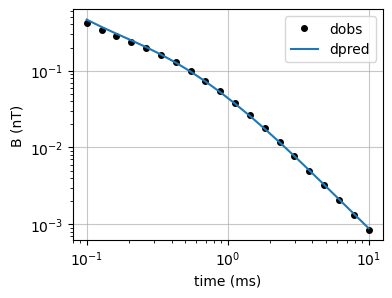

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

ax.loglog(rx_times*1e3, dobs*1e9, "ko", label="dobs", ms=4)
ax.loglog(rx_times*1e3, sim1d.dpred(recovered_model)*1e9, label="dpred")

ax.legend()
ax.grid("both", alpha=0.7)
ax.set_xlabel("time (ms)")
ax.set_ylabel("B (nT)")

Text(0.5, 0, 'conductivity (S/m)')

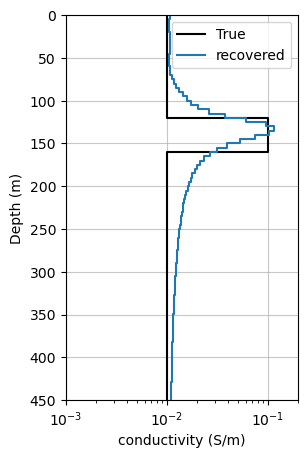

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(3, 5))

plot_1d_layer_model(sim1d_true.thicknesses, np.exp(m_true), ax=ax, color="k", label="True")
plot_1d_layer_model(mesh.h[0], np.exp(recovered_model), ax=ax, label="recovered")

ax.set_ylim([450, 0])
ax.set_xlim([1e-3, 2e-1])
ax.grid("both", alpha=0.7)
ax.legend()

ax.set_xlabel("conductivity (S/m)")